# "Chinese Keyword Extraction using Jieba"
> "text mining"

- toc: true 
- badges: true
- comments: true
- categories: [level-4, chapter-4, jieba, text-mining]
- image: images/key.jpg

Hello.  keyword extraction is one of the very popular technique in Natural Language Processing (NLP). It aims to extracting the most relevant words and expressions from text which can be further used to compare or summarize the text. Word clouds is also another example of keyword extraction. In this lesson we will learn about how to extract keywords in Chinese text using Python library [Jieba](https://github.com/fxsjy/jieba).

As mentioned in the [instructions](https://pinkychow1010.github.io/digital-chinese-history-blog/about/), you can click on the icon **"open in Colab"** to open the scirpt in a **Jupyter notebook** to run the code. It is highly recommended to follow the tutorials in the right order. 

# Set Up Environment

First of all, we have to set up our cloud environment in colab.

### Python Library

Download Library

The main library we need, **Jieba**, can be downloaded in Colab using **pip**.

In [2]:
! pip install jieba

Import Libraries

We will then import Jieba and other libraries we need.

In [3]:
from __future__ import unicode_literals
import sys
sys.path.append("../")

import jieba
import jieba.posseg
import jieba.analyse

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters
import time

### Google Drive
 
Connect to Google Drive

In order to access resources in your own Google Drive, we have to give the permission by running the following code.

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Download Resources using wget

In this lesson, there are two materials we need to download from the web. The first one is the Chinese font which we need to display characters in plot. The second one is a list of Chinese stopwords which we need for the tokenization. We can access both of them using **wget**.

Download Chinese Font

In [ ]:
# download Chinese font
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# after download, we have to add the font into the plotting library
# we need matplotlib.font_manager for that
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.font_manager import fontManager

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

Download Chinese Stopword List

From the github link, we can access the list of stopwords.

In [ ]:
! wget https://github.com/stopwords-iso/stopwords-zh/blob/master/stopwords-zh.txt -P /content/drive/MyDrive/

## Get our text 

In this example, we will use the text from **《时差》播客** titled: **宗教学：信仰，魔法，身份，权力**. You can find the source [here](https://m.thepaper.cn/newsDetail_forward_13762466). What we will do first is to count the frequency of keywords using simple statistics. Then, we will extract the keywords once again using [**TF-IDF**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), a specific technique for information retrieval with the use of weighing factors. Compared to the simple frequency counting methods, TF-IDF can better rank the relevance of words.

First, let's start simple. Part of the text is copied below and saved as `text`.

In [1]:
text = '''
郭婷：在今天节目开始之前，我想先表达一下沉痛的悼念，前几天有一位宗教学界的前辈，台大的林富士老师（1960-2021）去世了。我本来并不是研究中国宗教的，也不研究传统的中国文史哲，所以并没有和林老师见过面。但我一直从他的研究中得到灵感，所以非常感谢他。这两天也在脸书上，看到很多他过去的同事和学生对他的纪念。虽然学术界很多时候是一个有失公正的地方，但还是有一些地方让人觉得温暖，就好像点亮了一盏灯，而那盏灯一直会亮下去。
这一期我们来谈宗教学，不只是谈学界，也谈它的实践。在座几位虽然是跨学科的研究者或实践者，但也是宗教学出身。那我相信，大家在和别人介绍说自己研究宗教学的时候，通常会听到几个问题：一个是那你有没有宗教信仰？或者你研究哪一种宗教？以前还会听到的一个问题是，那你毕业之后做什么，是不是准备出家等等。
我以前会开玩笑说，对，以后出家给人算命。其实不只是学界之外，包括学界之内，不同学科对宗教学领域都会有一些陌生，因为它确实是一个比较特殊的学科。就我自己而言，我博士的训练在爱丁堡大学的神学院。爱大神学院作为一个新兴科系，比较有抗争精神和创新精神。它设立之初就是为了和传统的神学或者是和宗教有关的学科对抗，所以它非常讲究世俗化和社会科学方法。
我记得大部分宗教系的学者不论男女都打扮得非常不羁。在开会的时候，美国宗教学、尤其是圣经研究的学者尤其男性会打扮得非常闪亮，头发焗过、穿西装、带领带、鞋子都擦得很亮，但是英国宗教系的老师就穿得很随便。
而宗教学学科的训练讲究宗教和社会的关系、宗教和当下社会的关系。虽然我当时的研究是从AI人工智能切入，但其实是研究是英国的世俗化的情况。当然，在神学院也会碰到其他科系的同学，比如有旧约研究、新约研究，神学研究，然后也有一些道学博士或者是教牧学的学位。
那想请几位聊聊，你们的研究背景是怎么样的，也可以跟大家聊一下心路历程。
郑利昕：我接触的这些课程，是所谓的最传统的那种。芝加哥大学神学院的硕士英文是Master of Divinity，它不是一般的学术项目，是比较偏实践的，所以项目培养中有很多的实习、见习。芝加哥大学神学的M.A.，很多人进去的时候，都想着我以后要读宗教学或者相关学科的博士，那么读硕士是一个基本的门槛。
当我进入了项目以后，我发现它有神务硕士的项目，比较偏实践，非常有趣。在进神学院之前，我不知道学院内有这个项目，因为一般来说传统上只有基督教徒才会说以后我要作为神学人员，我需要读这个神学硕士。
但是神学院在最近10年产生了一些变化，它开始接受不同宗教的人进入神务硕士项目。所以我们班上会有基督教、犹太教、佛教、伊斯兰教、印度教，还有以人文主义者，或者人本主义者的身份进入项目的。所以我也算误打误撞进入了宗教学或者宗教实践的领域。
在进入神学院前，我是学物理的，物理博士读到一半发现人生好没有意义，我之后要去当码农了，所以想找一个有意义的专业。在寻找包括哲学、人类学之后，发现我对宗教学最感兴趣，后面又发现我最感兴趣的不是宗教学，而是宗教实践，或者说是以传统的宗教实践为启发的、一种比较广泛的社会实践的形式。
倪湛舸：利昕是在芝加哥大学读的神学硕士，我是在同样一个地方接受的宗教学教育，但是我是读完硕士去那里读的博士，芝加哥大学的神学院比较特别，它其实是一个大的宗教学中心。像刚刚提到的，芝加哥大学的硕士项目也涵盖各个宗教，虽然说起来是各个宗教，但是肯定也不会全部覆盖，只是尽力去吸纳。在博士阶段，很多年前我们是有9个项目，就像系科一样。
刚才郭婷有聊到旧约、新约研究，这些神学院的传统科目，在芝加哥大学还有宗教历史，宗教社会学，宗教人类学，当年还有宗教心理学。
在基督教之外，像宗教历史，当年有J. Z. Smith等一大帮人他们什么都做、什么都比较，现在相对来说走向了衰落，受到了批判，所以后来会有专门的伊斯兰研究。我的专业其实是叫宗教与文学，现在叫做宗教、文学与视觉艺术，又加了一个东西，想把电影包括进来，理论上也包括电影、电视、电子游戏。
不同的学校的神学院的风格也不一样，芝加哥大学可能偏向宗教学，而不是神学。相比之下，杜克、耶鲁和哈佛的神学院更加接近于神学。
郑利昕：我刚查了一下，现在的研究领域变成了11个了。包括宗教社会学，现在已经正式地变为宗教社会学与人类学。
倪湛舸：其实当年就已经很有人类学的痕迹了，我们当时都是一定要读Talal Asad，跟着Bruce Lincoln学。
郭婷：其实芝加哥神学院确实有这个传统，比较讲究宗教学传统，是比较特别的一个神学院。刚才湛舸提到的这些学者，包括芝加哥大学的J.Z. Smith，对于学宗教学的人来说，都是最经典的一些学者，大家都要读。
当然现在越来越多的神学院也好，宗教学研究也好，会去研究世界宗教和不同的宗教传统。在英国，这两年出现了一件非常有争议的事，我们当时神学院的本科课程，它有专门的一门课叫世界宗教，其实是一个殖民思维的产物，以基督教为中心，将“其它”宗教纳入“世界宗教”。这个概念现在非常有争议性，学界在努力解构它的同时提出新的范式。
后来神学院里面也有伊斯兰研究，但是还没有其他例如佛学研究，因为佛学研究跟伊斯兰、犹太教研究很多时候都属于亚洲研究，这就是区域研究和所谓的正式学科研究之间的张力。这也给学院派的研究带来了很多问题。
我们今天的另外两位嘉宾，李纪跟程晓文教授，她们的跨学科研究其实就汇合了汉学、历史学，中国研究，这些其实是存在一些交叉性的。那也想了解一下你们在进入宗教学或者是进入学术研究的时候整个的心路历程。
程晓文：我大学念的是中文系。之后在台大念硕士的时候，主修思想史。到了美国以后，我在华盛顿大学念是历史系博士，跟Patricia Ebrey开始做宋史。
真的开始披上宗教学的外衣，其实是拿到我现在这个研究东亚宗教的工作。然我来宾大的前一年，刚好在哈佛神学院做一年的研究员。所以我就可以谎称自己做的是宗教。我还记得我拿到这个工作之后，所有不管是认识我还是不认识我的人，第一个反应就是——可你又不做宗教。结果我这工作做着做着，我仿佛也做起了宗教现在我每年都教跟宗教有关的课，所以我对宗教这个东西是很感兴趣的。
其实我在大学时代是一个基本教义派的、福音派的基督教徒，是最传统的基督徒。我以前是非常认真的，那时候还去修古希腊文什么的。后来我也有一个过程，慢慢就不去教会了，然后就不认为自己是一个基督徒了。但是我对于宗教信仰这件事情，是非常可以理解的，它是一个大家需要认真看待的事情。我觉得我们不应该仅仅从社会学的角度去分析，它其实是一件非常有趣的东西。它可以让我们重新思考很多我们做研究时候会忽略的一些问题，跟我们常有的一些可能错误的假设。
郭婷：其实大家如果听“新书介绍”（new books network）这个播客的话，大家可能知道程老师最近有一本新书，在播客上有一段非常精彩的访谈，这本书是叫《神，魔，乱：没有男性的宋代女性（Divine, Demonic, and Disordered: Women without Men in Song Dynasty China）》。我当时听这本书觉得讲得非常精彩，也讲到了学术训练的一些心路历程。然后其实我们有一个共同朋友Donovan Schaefer，你们都在宗教系？
程晓文：我在东亚系，他在宗教系。我纯粹是在东亚系。但是对当初我的职位是一个东亚宗教研究的跨系招聘，它会在不同的系设置一个跟宗教有关的职位。
郭婷：原来如此，其实是我们这种跨学科的研究者在找工作的时候经常要遇到的问题，看似好像什么都可以申请，但工作其实都要看很多机缘巧合，也要看学校现在的方向怎样的。那台湾地区的基督徒，像在台大有自己的学生团契吗？
程晓文：它有好几个不同的教派。我的那个叫校园团契，在台湾地区也是一个全国性的机构。它的重点就是做学生工作，在中学还有大学去帮学生训练，做组织等等。还有一个团契叫学员团契，性质类似。还有一些可能像比较大的教会组织就会有自己的聚会所，它最早好像是英国的某一个兄弟会的一个分支，和倪柝声有关。当时我在的聚会所思想比较开放，我这辈子第一次听到女性主义是在那个团契里面。
郭婷：原来倪柝声的教会现在在台湾地区以这种方式生长。
我前几天还刚在看连曦老师的书。他之前有写倪柝声，在《浴火得救（Redeemed by Fire）》这本书里。之前还看过另外一本书，关于倪柝声的家人、后辈，那本书叫《上海信徒（Shanghai Faithful）》，讲到林家在福建做传教士家族的厨师，由于他的曾祖父非常聪慧，传教士便资助他的学业，让他去上海读神学院。读的是圣约翰大学，做了林语堂的同学。他的太太是倪柝声的妹妹。这本书写到许多传奇人物的真实历史。
我自己的感觉是，在中国大陆接触宗教和在台湾地区接触宗教是不同的。因为在台湾，宗教可能相对可见程度、能见程度更高，学校也有不同的团契。当然，我记得在2000年后半读大学的时候社会风气比较自由，还可以看到非常多韩国的传教士。有很多华人研究宗教学的朋友，其实都是因为教会的关系接触到宗教。
可惜我不是这样，大家都问我是因为什么原因接触宗教学，其实我是因为一个人工智能的问题。我本科读的也是宗教学，有宗教哲学这门课，课上提到说如果一个人出了车祸，他的脸都被烧毁了，然后医生给他换了一张脸，他在镜子里面不认识自己，他还是不是他？就是一个人格同一性的问题。当时我就说，天哪，世上有那么有趣的问题，如果我出车祸，我还是不是我，我一定要研究这个问题。
当时就问老师，我要研究这个问题，我应该进哪一个学校，进哪一个科系研究。结果当时不知道谁说你应该研究人工智能，这是人工智能哲学的问题。后来我申请学校的时候就选了人工智能哲学方向，谁知道人工智能其实是非常理工科的，我就花了非常多的时间去研究科学史和人工智能哲学，后来才渐渐进入了宗教学的领域。
再请李纪老师来聊一下是怎么从历史学进入宗教学这个领域的。
李纪：谢谢郭婷，刚才晓文老师说她是离宗教最远的，其实我本来也想说这句话。我的求学经历很简单，我从本科、硕士到博士都一直是历史系。我在北京大学历史系读了本科和硕士，我的本科专业是法国史，本科毕业论文是关于法国大革命的。在我那个年代，我的法国史老师是国内法国研究的权威，但是ta接受的法国史的系统训练还是传统的革命史研究，当时宗教是不进入法国大革命研究的。
所以在我到美国去读博士的时候，我的研究计划其实是“性别和革命的比较研究”，那时候读了一些新文化史对法国的心态史、性别研究；在90年代末、2000年初，这些在大陆是很新鲜的新史学，我当时就觉得这是我想做的。在做硕士论文的时候，我已经就开始在思考大革命起源，我做的是关于当时的书籍、沙龙，也有对巴黎的想象，因此写了这样一个研究计划。
到了美国第一年，我在密歇根大学的历史系，主要是研究欧洲史领域，还是想做大革命。我记得第一学期，我参加了一个关于大革命的研讨会，当时在威斯康辛遇到一个做法国研究的一个美国学者，他看我第一眼就对我说，我听说你想做法国大革命，让我想一想还有什么话题没有人碰过。当时才发现200年以来，法国大革命的点点滴滴，你能想到的任何东西，从日常生活到议会，每一个方方面都被人研究过了。所以我当时就想，我该怎么办，而且相对我的同学来说，虽然我也学法语，但是我还没有去过法国，没有真正进入过档案馆，因此我也非常焦虑。
学了两年欧洲的各种课程，到第三年要开题的时候，我就想我还是想做一个跟中国相关的题目。既然法语比不过人家，那我还是做一点能够用到中文材料的研究，当时就看中法之间有什么联络。除了大革命中很局限的一部分以外，那从历史上来看，传教士肯定是一个很大的团体。
所以我就去了法国，大概是第二年还是第三年的暑假，正好那两年有一个巴黎的高等研究院的教授长期在密歇根大学做客座教授。那一位教授他自己是做书籍史的，我到了巴黎的第一天，他就从机场接我直接到了巴黎外方传教会的档案馆。那是一个17世纪的神学院，一个修会。那是我第一次走进一个修院，一个17世纪的建筑。它在巴黎第6区，旁边是当时的巴黎高等研究院，和Bon Marche百货公司。进去以后，先看到了小教堂，穿过大大的楼，进到他们的阅读室。
后来我就一直在那里，第一次去了两个月，接下来4年，基本上一半的时间都在巴黎。之后慢慢地就进入了宗教史，到现在我介绍自己的专业一般都说是宗教史或者社会史，也涉及一些性别研究。
我听了大家的故事，发现还是有很多不一样的地方，一个是我没有任何宗教学或者神学的训练，还有我一直做天主教，而且主要是在中国的法国的天主教传教团体、在华基督教史这样一个领域。如果你研究天主教，这种非常系统性的教会，尤其是在中国的传教，会被保守落后、非常制度化。跟大家现在谈那种宗教、弥撒、宗教生活是很不一样的。
那我来到港大以后，一直在研究所（香港人文社科研究所），后来才有joint appointment到了文学院。在研究所，大部分老师都是做宗教，他们做道教、民间宗教，或者是人类学。我在他们中间，经常都是唯一一个做基督教，而且是做天主教的研究者。我坐在里面，听他们各种各样的讨论，受到的冲击也特别大。
我自己的第一本书《上帝的女儿们：十九世纪东北的天主教女性（God’s Little Daughters: Catholic Women in Nineteenth-Century Manchuria）》，是非常传统的历史题目，是一个教会史，大概是讲法国天主教的传教史，在19世纪中国东北的发展。其中有一些很有趣的材料，特别关注了中国的几个守贞女，天主教的女性写给法国神父的信，从这样一个角度进入研究，但本身的结构还是传统的教会史。'''				

## Counting Frequency

Then, we can count the frequency of words (excluding stopwords) using Jieba. We need to read the stopwords from the text document. 

Read the text document using a path in Google Drive and split by every new line. We will get a list of words at the end.

In [7]:
path = "/content/drive/MyDrive/stopwords-zh.txt"

with open(path, 'r') as file:
    data = file.read()

stopwords = list(data.split("\n"))

We will add a few other stopwords into the list too.

In [8]:
stopwords.append(" ")
stopwords.append("\n")
stopwords.append(".")
stopwords.append(",")

We need to enable paddle to improve performance for Chinese tokenization. Using **jieba.lcut_for_search()**, we can then segment the text into words. To build a dictionary for word frequency, we can use **dictionary comprehension**. It is very similar to list comprehension, but use { } instead. We also have to assign both **keys** and **values**. You can learn more about this in the [previous tutorial](https://pinkychow1010.github.io/digital-chinese-history-blog/chapter-1/level-1/programming/2020/01/25/List_Comprehension_Basics.html). We will save the resulting dictionary to `count`.

In [9]:
jieba.enable_paddle()
words = jieba.posseg.jieba.lcut_for_search(text)

count = {i:words.count(i) for i in set(words) if i not in stopwords}
count

Paddle enabled successfully......


{'末': 1,
 '其他': 2,
 '落后': 1,
 '要读': 2,
 '结果': 2,
 '祖父': 1,
 '两年': 3,
 '共同': 1,
 '看过': 1,
 'Daughters': 1,
 '许多': 1,
 '九世纪': 1,
 '除了': 1,
 '看中': 1,
 '就': 24,
 '点点滴滴': 1,
 '日常': 1,
 '研究员': 1,
 '看似': 1,
 '学期': 1,
 '亚洲': 1,
 '19': 1,
 '节目': 1,
 '聊到': 1,
 '和': 18,
 '外衣': 1,
 '过程': 1,
 '如此': 1,
 '程晓文': 4,
 '；': 1,
 '研究所': 3,
 '暑假': 1,
 '变成': 1,
 '产物': 1,
 '百货公司': 1,
 '本科课程': 1,
 '人': 9,
 '那里': 2,
 '想到': 1,
 'Marche': 1,
 '好像': 3,
 '电影': 2,
 '写': 2,
 '电视': 1,
 '形式': 1,
 '一盏灯': 1,
 '话题': 1,
 '内有': 1,
 '一盏': 1,
 '可能': 5,
 'Disordered': 1,
 '书籍': 2,
 '材料': 2,
 '天主': 7,
 '大陆': 2,
 '当下': 1,
 '算': 1,
 '不羁': 1,
 '家人': 1,
 '启发': 1,
 '局限': 1,
 '再': 1,
 '会亮': 1,
 '同学': 3,
 '尽力': 1,
 '魔': 1,
 '系': 7,
 '百货': 1,
 '在座': 1,
 '覆盖': 1,
 '威斯': 1,
 '东北': 2,
 '女': 1,
 '论文': 2,
 '年代': 2,
 '发现': 6,
 '学位': 1,
 '方向': 2,
 '美国': 5,
 '怎么办': 1,
 '点点': 1,
 '这辈子': 1,
 '游戏': 1,
 '了解': 1,
 '用到': 1,
 '焦虑': 1,
 '前辈': 1,
 'Divine': 1,
 '心路': 3,
 'Manchuria': 1,
 '但是': 9,
 '做起': 1,
 'of': 1,
 '过': 3,
 '访谈': 1,
 '第一眼': 1,
 '中有':

Nonetheless, it is more convenient to have the word frequency in a **Pandas** data frame. We can easily do that by taking the `items()` of count in a list. We will create the data frame using `pd.DataFrame()`. You can learn more about Pandas in the [data organization chapter](https://pinkychow1010.github.io/digital-chinese-history-blog/level-2/chapter-2/data-manipulation/pandas/2020/01/23/Pandas_TextAnalysis_TextOriganization.html).

In [ ]:
items = count.items()
data_list = list(items)
df = pd.DataFrame(data=data_list)
df.columns = ["word", "frequency"]
df.head()

,word,frequency
0,法国,21
1,承担,1
2,天主教,37
3,洞,1
4,打扮,2


To inspect what words most frequently appear in the text, we can also sort the values. We will take the top 10 into a new data frame and set the keyword as **index**. Now, we start to see some interesting patterns: **宗教**, **研究**, and **基督** appear the most. Another interesting keyword includes **女性**.

In [ ]:
df = df.sort_values(by='frequency', ascending=False).reset_index()
df_top = df.head(10)[["word","frequency"]]
df_top.index = df_top.word
df_top

,word,frequency
word,,
宗教,宗教,264
研究,研究,163
基督,基督,64
基督教,基督教,55
社会,社会,54
女性,女性,53
历史,历史,52
中国,中国,51
现在,现在,49


## Data Visualization

We can already do a basic data visualization using **matplotlib**. In this library, we can select different plotting styles. We will pick `'Solarize_Light2'` here.

<br>

Checking available styles

In [ ]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


Plotting a horizontal bar chart using Pandas.

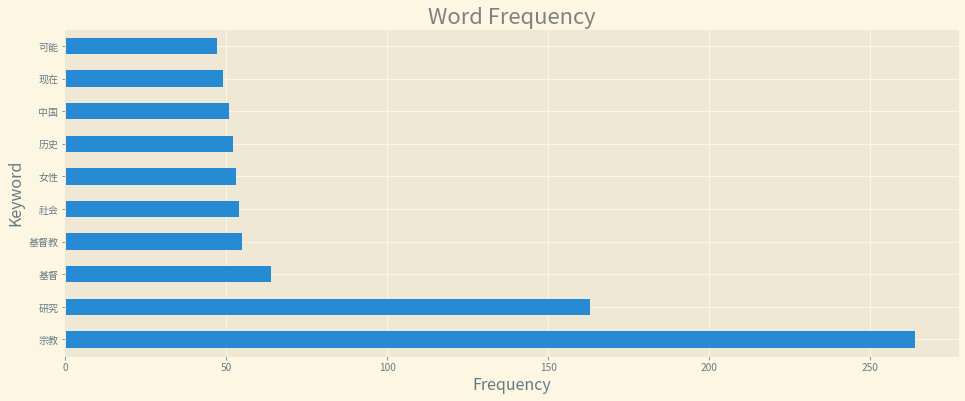

In [ ]:
# style use
plt.style.use('Solarize_Light2')

# plotting with defined figure size and without legend
df_top.plot.barh(figsize=(16,6), legend=None)

# layout
plt.title("Word Frequency", fontsize=22, color="grey")
plt.xlabel("Frequency", fontsize=16)
plt.ylabel("Keyword", fontsize=16)

# diplay
plt.show()

# Chinese Keyword Extraction

## **TF-IDF**

TF-IDF (term frequency-inverse document frequency) is a technique used in automated text analysis. It is a **statistical measure** which evaluates how relevant a word is in the text. In **TF-IDF**, two metrics are computed: how many times a word appears in a document, and the inverse document frequency of the word across the document. **Keywords** are the words that score the highest in a document, which also means they are the most **relevant**. They are selected because they are not so common in general but commonly appeared in the text. In the Chinese NLP library **jieba**, it is calculated by comparing the words to a pre-defined document. 

Using jieba to extract keywords, we do not need to calculate the frequency of words ourselves, but can simply use the function **analyse.extract_tags()**.

Let's extract keywords once again, but this time using extract_tags(). The keywords appear to be slightly different.

In [ ]:
# extract 10 tags
tags = jieba.analyse.extract_tags(text, topK=10)

# print results
print(",".join(tags))

宗教,宗教学,研究,神学院,一个,其实,硕士,非常,郭婷,团契


We can get the keywords with weights too. By doing so, we also get a number from 0 to 1, which represents the relevance of words.

In [ ]:
for x, w in jieba.analyse.extract_tags(text, withWeight=True):
    print(x,w)

宗教 0.18120946434784116
宗教学 0.14646094768094117
研究 0.12716916499852943
神学院 0.11163790487320586
一个 0.07458223161520589
其实 0.06334097453756471
硕士 0.05739566884492941
非常 0.05480139830615294
郭婷 0.04922551324723529
团契 0.04906121524235295
当时 0.044007932553882356
神学 0.04393354675288235
芝加哥大学 0.04258187006145882
传统 0.04093881529086471
时候 0.040364671373552936
大革命 0.03950751113430589
人工智能 0.03894481456966471
博士 0.038879466860223526
法国 0.03784607501089412
老师 0.03749071607411765


## Define Stopwords

But here we have not defined the stopwords yet. By setting a list of stopwords, we can prevent some common words appear to be keywords. It can be done using **analyse.set_stop_words()**. We need to pass a text file (.txt) **[Encoding UTF-8]** to this function. You can download it [here](https://github.com/stopwords-iso/stopwords-zh/blob/master/stopwords-zh.txt) and edit it as you like. topK is used to define the number of keywords extracted, we will set it to 10 here.

In [ ]:
# set stop words
jieba.analyse.set_stop_words(r"/content/drive/MyDrive/NLP/stopwords.txt")

# extract keywords again
tags = jieba.analyse.extract_tags(text, topK=10)

# print results
print(",".join(tags))

宗教,宗教学,研究,神学院,硕士,团契,神学,芝加哥大学,传统,大革命


With the weights

In [ ]:
for x, w in jieba.analyse.extract_tags(text, withWeight=True):
    print(x,w)

宗教 0.24507246570511534
宗教学 0.19807765398377086
研究 0.17198693754773273
神学院 0.15098205114116944
硕士 0.07762341848558472
团契 0.06635168330310262
神学 0.059416889005489255
芝加哥大学 0.05758884574739856
传统 0.05536673507913285
大革命 0.05343100153406524
人工智能 0.05266999583805092
博士 0.05258161786983294
法国 0.05118403143875895
老师 0.050703434626889414
比较 0.04934998856252983
倪柝声 0.04755277447454256
进入 0.04718182956929196
教会 0.04180557540669053
天主教 0.041445008417191724
程晓文 0.038042219579634044


The results are a little bit different from above compared to just counting the frequency. We get other keywords such as **传统** and **大革命**.

## Summary

You might have wondered: What if we do not want to copy the long text, but directly get the text from the web, such as from a digital text database? Or to get the text from multiple web pages, such as getting all the blogs published this year? Or, can we further simplify our workflow? 

Of course, it can all be achieved using functions, loops, and the powerful web scraping library **BeautifulSoup**. Another question is, can we search for specific keywords that we are interested in? The answer is also yes. We will learn more about them in further tutorials. **Stay tuned!**

<br>
<br>

***

## **Additional information**

This notebook is provided for educational purpose and feel free to report any issue on GitHub.

<br>

**Author:** Ka Hei, Chow

**License:** The code in this notebook is licensed under the [Creative Commons by Attribution 4.0 license](https://creativecommons.org/licenses/by/4.0/).

**Last modified:** February 2022